In [10]:
import matplotlib.pyplot as plt
import numpy as np
from pyslfp import FingerPrint, plot, IceModel
from joblib import Parallel, delayed
import pandas as pd
import seaborn as sns

from Part_III_Project import sea_surface_height_change as sshc

sns.set_theme(style="ticks", palette="muted")

## Variable setting

In [11]:
lmax = 128

resolution = 10  # number of points from -90 to 90 degrees

fields = 1000

length_scales = [0.005, 0.1]
# length_scales = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5]

## Pre-calculate length scales and resolutions

In [41]:
satellite_ranges = np.round(np.linspace(1, 90, resolution), 2)
fp = FingerPrint(lmax=lmax)
fp.set_state_from_ice_ng(version=IceModel.ICE7G, date=0.0)

X = fp.lebesgue_load_space()


# Function to generate a single sample for a given length scale
def generate_single_sample(length_scale, sample_idx):
    mu = X.heat_kernel_gaussian_measure(length_scale * fp.mean_sea_floor_radius)
    return length_scale, sample_idx, mu.sample()


# Generate all combinations of length scales and sample indices
tasks = [
    (length_scale, sample_idx)
    for length_scale in length_scales
    for sample_idx in range(fields)
]

print(
    f"Generating {len(tasks)} total samples across {len(length_scales)} length scales..."
)

# Parallelize all sample generation at once
results = Parallel(n_jobs=-1, verbose=10)(
    delayed(generate_single_sample)(length_scale, sample_idx)
    for length_scale, sample_idx in tasks
)

# Organize results by length scale
all_errors = {ls: {"fields": []} for ls in length_scales}

for length_scale, sample_idx, sample in results:
    all_errors[length_scale]["fields"].append(sample)

# Convert lists to numpy arrays
for length_scale in length_scales:
    all_errors[length_scale]["fields"] = np.array(all_errors[length_scale]["fields"])


Generating 2000 total samples across 2 length scales...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.02134990692138672s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.07154417037963867s.) Setting batch_size=4.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done  72 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Batch computation too fast (0.11539411544799805s.) Setting batch_size=8.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 304 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 424 tasks      | elapsed:    0.8s
[Parallel(n_job

## Precompute altimetry weighting functions for all satellite ranges in parallel

In [42]:
def compute_altimetry_weighting_function(satellite_range):
    """Compute altimetry weighting function for a given satellite range."""
    altimetry_projection = fp.altimetry_projection(
        latitude_min=-satellite_range, latitude_max=satellite_range, value=0
    )
    altimetry_projection_integral = fp.integrate(altimetry_projection)
    altimetry_weighting_function = altimetry_projection / altimetry_projection_integral
    return altimetry_weighting_function


altimetry_weighting_functions = Parallel(n_jobs=-1, verbose=10)(
    delayed(compute_altimetry_weighting_function)(satellite_range)
    for satellite_range in satellite_ranges
)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Batch computation too fast (0.007980823516845703s.) Setting batch_size=2.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    0.0s finished


## Function setting

In [ ]:
def compute_sshchange_and_mean_for_field(field):
    """Compute sea surface height change and mean sea level change for a given field."""
    direct_load = field * fp.ice_projection(value=0)

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sshchange = sshc(
        fp,
        sea_level_change,
        displacement,
        angular_velocity_change,
    )

    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    return sshchange, mean_sea_level_change


def compute_error_for_satellite_range(
    sshchange, mean_sea_level_change, altimetry_weighting_function
):
    """Compute estimation error for a given satellite range."""
    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sshchange
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )
    return error


data = pd.DataFrame()


def compute_all_for_field_and_satrange(
    length_scale, field, sat_range, altimetry_weighting_function
):
    """Compute SSH change, mean sea level change, and error for a specific field and satellite range."""
    direct_load = field * fp.ice_projection(value=0)

    (
        sea_level_change,
        displacement,
        gravitational_potential_change,
        angular_velocity_change,
    ) = fp(direct_load=direct_load)

    sshchange = sshc(
        fp,
        sea_level_change,
        displacement,
        angular_velocity_change,
    )

    mean_sea_level_change = fp.mean_sea_level_change(direct_load)

    mean_sea_level_change_estimate = fp.integrate(
        altimetry_weighting_function * sshchange
    )

    error = (
        100
        * np.abs(mean_sea_level_change_estimate - mean_sea_level_change)
        / np.abs(mean_sea_level_change)
    )

    return {
        "length_scale": length_scale,
        "sat_range": sat_range,
        "error": error,
        "true_mean": mean_sea_level_change,
        "estimate": mean_sea_level_change_estimate,
    }


## Calc. SLC and SSHC and error

In [46]:
print(f"Number of jobs is {len(length_scales) * fields * resolution}")

# save errors, estimates, and true means for all in a dataframe, use parallel processing
# # Create all combinations of tasks
tasks = [
    (length_scale, field, sat_range, altimetry_weighting_function)
    for length_scale in length_scales
    for field in all_errors[length_scale]["fields"]
    for sat_range, altimetry_weighting_function in zip(
        satellite_ranges, altimetry_weighting_functions
    )
]

print(f"Processing {len(tasks)} total combinations in parallel...")

# Execute all tasks in a single parallel batch
results = Parallel(n_jobs=-1, verbose=2)(
    delayed(compute_all_for_field_and_satrange)(
        length_scale, field, sat_range, altimetry_weighting_function
    )
    for length_scale, field, sat_range, altimetry_weighting_function in tasks
)

# Extract results into lists
error_list = [r["error"] for r in results]
true_mean_list = [r["true_mean"] for r in results]
estimate_list = [r["estimate"] for r in results]
satallite_range_list = [r["sat_range"] for r in results]
length_scale_list = [r["length_scale"] for r in results]

Number of jobs is 20000
Processing 20000 total combinations in parallel...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 288 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 2232 tasks      | elapsed:   17.0s
/Users/th/Developer/Part_III_Project/.venv/lib/python3.14/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 3692 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 4572 tasks      | elapsed:   35.6s
[Parallel(n_jobs=-1)]: Done 5626 tasks      | elapsed:   42.8s
[Parallel(n_jobs=-1)]: Done 6840 tasks      | elapsed:   51.3s
[Parallel(n_jobs=-1)]: Done 8218 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 9756 tasks      | elapsed:  1.2min
[Parallel(n_job

In [116]:
# into dataframe

data = pd.DataFrame(
    {
        "length_scale": length_scale_list,
        "satellite_range": satallite_range_list,
        "error": error_list,
        "true_mean": true_mean_list,
        "estimate": estimate_list,
    }
)
data["num_error"] = data["estimate"] - data["true_mean"]
data.to_csv("random_field_errors.csv", index=False)

In [12]:
# read
data = pd.read_csv("random_field_errors.csv")

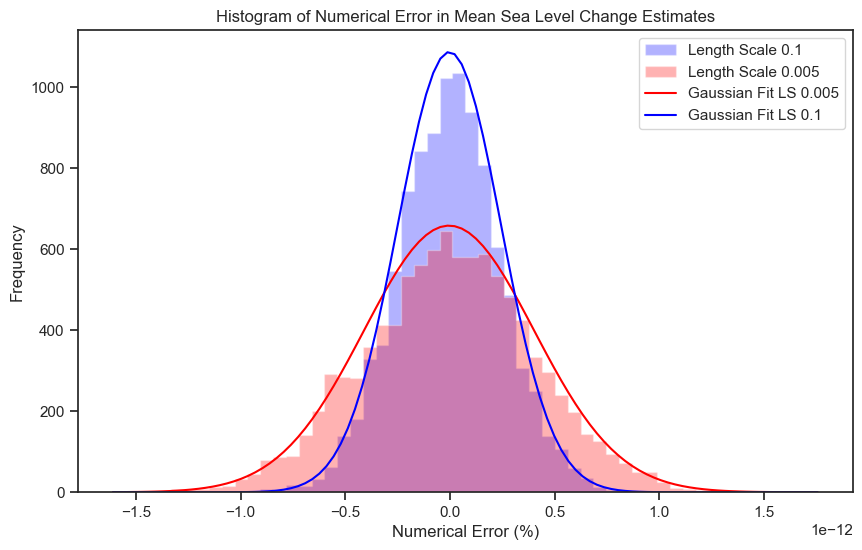

In [19]:
# histogram of numerical error per length scale
# color palette consistent with each plot
color = {0.005: "red", 0.1: "blue"}
plt.figure(figsize=(10, 6))
plt.hist(
    [data[data["length_scale"] == ls]["num_error"] for ls in length_scales],
    bins=50,
    label=[f"Length Scale {ls}" for ls in length_scales],
    alpha=0.3,
    density=False,
    color=[color[ls] for ls in length_scales],
    histtype="stepfilled",
)

# Overlay Gaussian distribution using seaborn and colors from the histogram
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
for length_scale in length_scales:
    subset = data[data["length_scale"] == length_scale]["num_error"]
    mu = subset.mean()
    sigma = subset.std()
    p = (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    plt.plot(
        x,
        p * len(subset) * (xmax - xmin) / 50,
        label=f"Gaussian Fit LS {length_scale}",
        color=color[length_scale],
    )

# plt.yscale("log")
plt.title("Histogram of Numerical Error in Mean Sea Level Change Estimates")
plt.xlabel("Numerical Error (%)")
plt.legend()
plt.ylabel("Frequency")
plt.show()

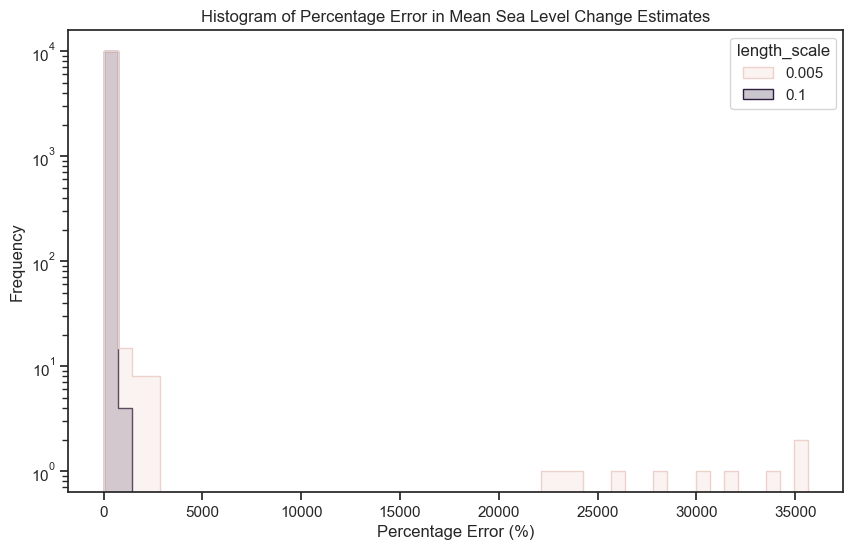

In [13]:
# histogram of error
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x="error", bins=50, hue="length_scale", element="step")
# log y axis
plt.yscale("log")
plt.title("Histogram of Percentage Error in Mean Sea Level Change Estimates")
plt.xlabel("Percentage Error (%)")
plt.ylabel("Frequency")
plt.show()

In [16]:
# remove any rows where error is over 300
data = data[data["error"] <= 1000]

In [56]:
# print range of error:
print(f"Error ranges from {data['error'].min()} to {data['error'].max()}")

Error ranges from 0.0007371013570515 to 587.1133598564448


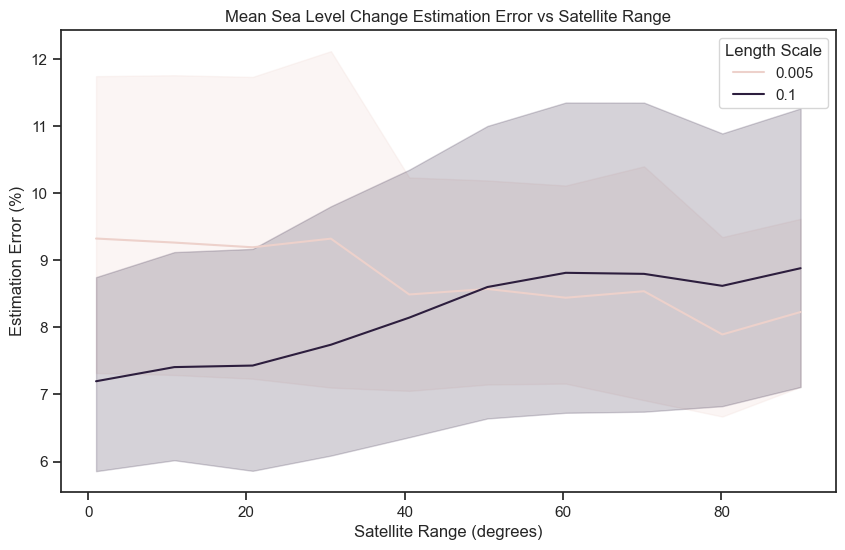

In [17]:
# plot error vs satellite range
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=data,
    x="satellite_range",
    y="error",
    hue="length_scale",
)

plt.title("Mean Sea Level Change Estimation Error vs Satellite Range")
plt.xlabel("Satellite Range (degrees)")
plt.ylabel("Estimation Error (%)")
plt.legend(title="Length Scale")